# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [26]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [ ]:
# Write your answer here

### Method to extract the data from several csv files and concatenate them

In [ ]:
def extraction_ebola(directory_name, country_name):
    
    files = [fn for fn in glob.glob(directory_name)]
    df_from_each_file = (pd.read_csv(f) for f in files)
    df = pd.concat(df_from_each_file, ignore_index=True)

    ##### Adding the Country name to the data frame
    country = [country_name] * len(df)
    country_df = pd.DataFrame({'country': country})
    df.join(country_df)
    
    return df
    
guinea_df = extraction1('Data/ebola/guinea_data/*', 'Guinea')
liberia_df = extraction1('Data/ebola/liberia_data/*', 'Liberia')
sierra_leone_df = extraction1('Data/ebola/sl_data/*', 'Sierra Leone')


### Keep only the new cases and new deaths

We first begin by characterize the different strings that are present in the csv files. This part could become necessary if ones want to add simply a new country to analyze. 

We first define in the 'country string' series the names of the different columns necessary. The 'search' series define the description that are interesting in our analysis, and the 'todrop' defines the ones that won't be kept. 

In [11]:
## STRINGS CHARACTERIZATION
noDrop = 0; toDrop = 1
suspected_percentage = 0.7 * np.ones(12)
probable_percentage = 0.3  * np.ones(12)

# Name of all columns in each csv files + Terms of interest
guinea_string =  ['Date','Description','Totals','New cases','New deaths registered today']
sierra_string =  ['date','variable','National','new_confirmed','death_confirmed']
liberia_string = ['Date','Variable','National','New case/s','Newly reported deaths']

# Search queries, and terms to drop
confirmed_search_cases =   ['New cases of confirmed', 'New case/s', 'new_confirmed']
search_deaths =            ['New deaths registered','Newly reported deaths','death_confirmed']
confirmed_to_drop_cases  = ['health']
confirmed_to_drop_deaths = ['health','probables', 'confirmed', 'suspects']

probable_search_cases  = ['New cases of probables','New Case/s \(Probable\)','new_probable']
suspected_search_cases = ['New cases of suspects','New case/s \(Suspected\)','new_suspected']

null_string = []

In [12]:
# Function to extract the wanted DataFrame for each cases (confirmed, probable or suspected) for each country
def search_dataframe(country_df, country_string, search_string, to_drop_string, variableDrop):
    
    final_df = country_df[country_df[country_string[1]].str.contains('|'.join(search_string))]
    
    if variableDrop == 1:
        final_df = final_df[~final_df[country_string[1]].str.contains('|'.join(to_drop_string))]
    
    final_df = final_df[pd.notnull(final_df[country_string[2]])]
    
    return final_df

guinea_confirmed_cases  = search_dataframe(guinea_df, guinea_string, confirmed_search_cases, confirmed_to_drop_cases, toDrop)
guinea_suspected_cases  = search_dataframe(guinea_df, guinea_string, suspected_search_cases, null_string, noDrop)
guinea_probable_cases   = search_dataframe(guinea_df, guinea_string, probable_search_cases, null_string, noDrop)
guinea_deaths = search_dataframe(guinea_df, guinea_string, search_deaths, confirmed_to_drop_deaths, toDrop)

liberia_confirmed_cases = search_dataframe(liberia_df, liberia_string, confirmed_search_cases, confirmed_to_drop_cases, noDrop)
liberia_suspected_cases = search_dataframe(liberia_df, liberia_string, suspected_search_cases, null_string, noDrop)
liberia_probable_cases  = search_dataframe(liberia_df, liberia_string, probable_search_cases, null_string, noDrop)
liberia_deaths = search_dataframe(liberia_df,liberia_string,search_deaths, null_string, noDrop)

sierra_confirmed_cases = search_dataframe(sierra_leone_df, sierra_string, confirmed_search_cases, confirmed_to_drop_cases, noDrop)
sierra_suspected_cases = search_dataframe(sierra_leone_df, sierra_string, suspected_search_cases, null_string, noDrop)
sierra_probable_cases  = search_dataframe(sierra_leone_df, sierra_string, probable_search_cases, null_string, noDrop)
sierra_deaths = search_dataframe(sierra_leone_df,sierra_string,search_deaths,null_string, noDrop)

We define a function 'day_average_per_month' that returns for a given country an array _cases_ containing the daily average for each month. The function takes as input the DataFrame of the country plus the previously defined string containing the names of the columns. In a for-loop, every month is passed onto review, the number of corresponding cases is summed. The total is then divided by the number of days where a measurement was made. 

The choice to not divide by the number of days in the month but by this observation comes from the lack of informations we have on the csv file. We don't know if the missing days corresponds to a lack of information, or that when a new file is created the new_cases and new_deaths values are counted from the previous measurement.

In [13]:
# Function to count number of cases per month + number of entries
def day_average_per_month(country_df, country_string):
    
    #Conversion to be able to extract the month from the date columns
    country_date = pd.to_datetime(country_df[country_string[0]])
    cases = []
    
    #Calculation for each month
    for i in range(1,13):
        #Creation of a new table with only the totals from the current month
        toSum = country_df.loc[country_date.dt.month == i,country_string[2]]
        toSum = toSum.reset_index(drop=True)
        
        #Summing all values for the month
        daily_cases  = [ int(x) for x in toSum]
        month_sum = sum(daily_cases)
        
        # Let's avoid to divide by 0
        if toSum.shape[0] == 0:
            day_average = 0
        # Day average calculated as the total sum of the month divided by the number of days that were registered    
        else:
            day_average = month_sum/float(toSum.shape[0])
            
        cases.append(day_average)
        
    return cases

In [14]:
# We delete the last few lines of Liberia as they seem false. Commentary below in the Discussion
liberia_confirmed_cases = liberia_confirmed_cases[:-6]
liberia_suspected_cases = liberia_suspected_cases[:-6]
liberia_probable_cases = liberia_probable_cases[:-6]

# Calculation of the different values
da_cases_guinea  =    day_average_per_month(guinea_confirmed_cases, guinea_string) \
                    + probable_percentage  * day_average_per_month(guinea_probable_cases, guinea_string) \
                    + suspected_percentage * day_average_per_month(guinea_suspected_cases, guinea_string);
da_cases_liberia =    day_average_per_month(liberia_confirmed_cases, liberia_string) \
                    + probable_percentage  * day_average_per_month(liberia_probable_cases, liberia_string) \
                    + suspected_percentage * day_average_per_month(liberia_suspected_cases, liberia_string);
da_cases_sierra  =    day_average_per_month(sierra_confirmed_cases, sierra_string) \
                    + probable_percentage  * day_average_per_month(sierra_probable_cases, sierra_string) \
                    + suspected_percentage * day_average_per_month(sierra_suspected_cases, sierra_string);

da_deaths_guinea = day_average_per_month(guinea_deaths, guinea_string);
da_deaths_liberia = day_average_per_month(liberia_deaths, liberia_string);
da_deaths_sierra = day_average_per_month(sierra_deaths, sierra_string);

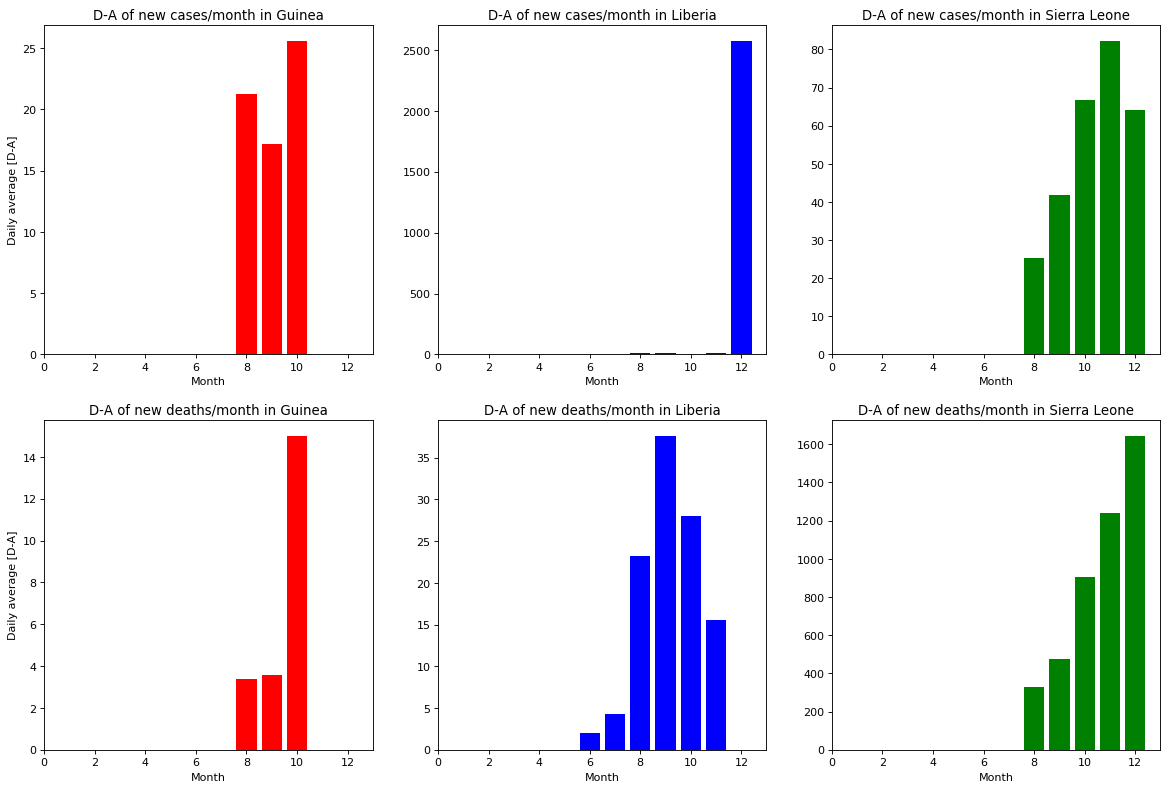

In [27]:
# Total Plot

fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
month = np.linspace(1,12,12)

plt.subplot(2, 3, 1)
plt.bar(month,da_cases_guinea, color = "red")
plt.xlabel('Month')
plt.ylabel('Daily average [D-A]')
plt.title('D-A of new cases/month in Guinea')

plt.subplot(2, 3, 4)
plt.bar(month,da_deaths_guinea, color = "red")
plt.xlabel('Month')
plt.ylabel('Daily average [D-A]')
plt.title('D-A of new deaths/month in Guinea')

plt.subplot(2, 3, 2)
plt.bar(month,da_cases_liberia, color = "blue")
plt.xlabel('Month')
plt.title('D-A of new cases/month in Liberia')

plt.subplot(2, 3, 5)
plt.bar(month,da_deaths_liberia, color = "blue")
plt.xlabel('Month')
plt.title('D-A of new deaths/month in Liberia')

plt.subplot(2, 3, 3)
plt.bar(month,da_cases_sierra, color = "green")
plt.xlabel('Month')
plt.title('D-A of new cases/month in Sierra Leone')

plt.subplot(2, 3, 6)
plt.bar(month,da_deaths_sierra, color = "green")
plt.xlabel('Month')
plt.title('D-A of new deaths/month in Sierra Leone')

plt.show()

In [16]:
# Final DataFrame with all the data

final_df = pd.DataFrame(
    {('Guinea','New Cases'): da_cases_guinea, ('Guinea','New Deaths'): da_deaths_guinea,
     ('Liberia','New Cases'): da_cases_liberia, ('Liberia','New Deaths'): da_deaths_liberia,
     ('Sierra Leone','New Cases'): da_cases_sierra, ('Sierra Leone','New Deaths'): da_deaths_sierra,
    })
final_df

Guinea                 Liberia            Sierra Leone             
   New Cases New Deaths    New Cases New Deaths    New Cases   New Deaths
0     0.0000     0.0000     0.000000   0.000000     0.000000     0.000000
1     0.0000     0.0000     0.000000   0.000000     0.000000     0.000000
2     0.0000     0.0000     0.000000   0.000000     0.000000     0.000000
3     0.0000     0.0000     0.000000   0.000000     0.000000     0.000000
4     0.0000     0.0000     0.000000   0.000000     0.000000     0.000000
5     0.0000     0.0000     2.516667   2.000000     0.000000     0.000000
6     0.0000     0.0000     2.936364   4.272727     0.000000     0.000000
7    21.2600     3.4000     9.537500  23.222222    25.233333   326.500000
8    17.1625     3.5625    15.060870  37.608696    41.862963   476.148148
9    25.6000    15.0000     6.312500  28.040000    66.677249   905.464286
10    0.0000     0.0000    12.284848  15.538462    82.310526  1241.105263
11    0.0000     0.0000  2577.075000   0.000000    64.133333  1643.500000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [17]:
# Write your answer here

### Extraction of the spreadsheets

This method extract the data from the nine excel sheets and create a DataFrame from them. It also return nine DataFrames, one for each spreadsheet. They are used to determine the number of element in each spreadsheets when the metadata are added

In [18]:
def extraction_microbiome(directory_name, exclude_file):
    
    files = [fn for fn in glob.glob(directory_name) if not os.path.basename(fn).startswith(exclude_file)]
    data_frames = []

    for f in files:
        data_frames.append(pd.read_excel(f, names = ['TAXON', 'COUNT'])) 
    
    df = pd.concat([d for d in data_frames])
    
    #Reset the indexes to avoid duplicates. This create a column named 'index' that we don't need so its deleted
    df = df.reset_index()
    del df['index']
    
    return df, data_frames

In [19]:
taxon_df, taxon_data_frames = extraction_microbiome(DATA_FOLDER+'/microbiome/*.xls', 'metadata')

The metadata are extracted, and duplicated to match the size of our DataFrame

In [20]:
metadata = pd.read_excel(DATA_FOLDER+'/microbiome/metadata.xls')
meta = []
for i in range(0, len(metadata)):
    for j in range(0, len(taxon_data_frames[i])):
        meta.append(metadata.values[i])

A DataFrame containing the metadata is created and is concatenated to the Taxon DataFrame. The Nan values are replaced by 'unknown'

In [21]:
meta_df = pd.DataFrame(meta, columns=['BARCODE', 'GROUP', 'SAMPLE'])
result = pd.concat([taxon_df, meta_df], axis=1)
result = result.fillna('unknown');
result

,TAXON,COUNT,BARCODE,GROUP,SAMPLE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID1,EXTRACTION CONTROL,unknown
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,MID1,EXTRACTION CONTROL,unknown
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1,EXTRACTION CONTROL,unknown
3,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,MID1,EXTRACTION CONTROL,unknown
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",4,MID1,EXTRACTION CONTROL,unknown
5,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",4,MID1,EXTRACTION CONTROL,unknown
6,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",1,MID1,EXTRACTION CONTROL,unknown
7,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",12,MID1,EXTRACTION CONTROL,unknown
8,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",2,MID1,EXTRACTION CONTROL,unknown
9,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

#### 1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 

In [106]:
titanicData = pd.read_excel(DATA_FOLDER + '/titanic.xls')
titanicData

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


Attributes that can be Categorical :
- pclass : first, second or third class
- survived : if the subject has survived or not
- sex : male or female -> transform sex attribut (female=0 male=1), pour plus de facilité d'utilisation
- (slibsp : accompanied or not) vu que ça dépend de la personne c'est en pas vraiment ou bien ?
- embarked : where the subject has embarked
- boat : in which boat the subject run away

In [107]:
## Change sex attribut to a categorical attribut
titanicData['sex'] = titanicData['sex'].replace('female', 0)
titanicData['sex'] = titanicData['sex'].replace('male', 1)

#### 2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

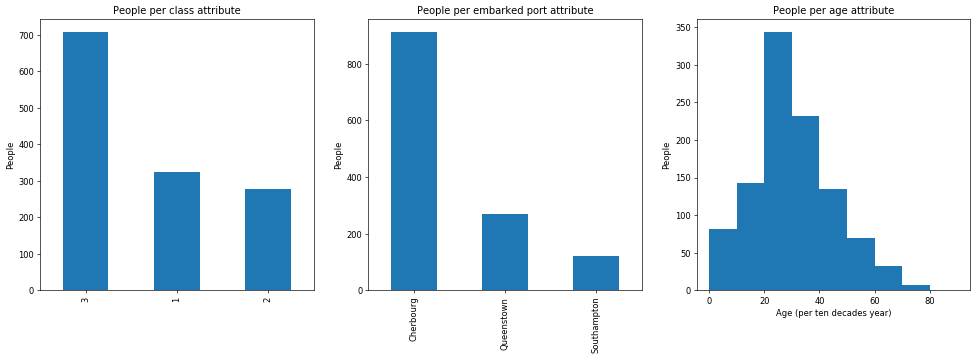

In [108]:
# Total Plot

fig=plt.figure(figsize=(20, 6), dpi= 60, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
# Histograms for travel class attributes
df = titanicData.pclass.astype('category')
classPlot = df.value_counts().plot(kind='bar')
classPlot.set_title("People per class attribute")
classPlot.set_ylabel("People")

plt.subplot(1, 3, 2)
df = titanicData.embarked.astype('category')
embarkedPlot = df.value_counts().plot(kind='bar')
embarkedPlot.set_title("People per embarked port attribute")
embarkedPlot.set_ylabel("People")
embarkedPlot.set_xticklabels(["Cherbourg", "Queenstown", "Southampton"])

#############
# Histogram for age attributes with discrete intervals ([0,10])

begin, end, interval = 10, 100, 10

titanicDataTmp, ageDiscret, ageInd = titanicData.sort_values(['age']), [], list(range(begin, end, interval))

# Count the number of people in each interval of ten years
ageDiscret.append(titanicDataTmp.query('age < 10').shape[0])

for i in range(20,100,interval):
    j = i - 10
    ageDiscret.append(titanicDataTmp.query('age < @i').shape[0] - titanicDataTmp.query('age < @j').shape[0])    
#############

plt.subplot(1, 3, 3)
# Bar plot   
plt.bar(ageInd, ageDiscret,  width = -10, align = 'edge')
plt.title("People per age attribute")
plt.xlabel("Age (per ten decades year)")
plt.ylabel("People")
plt.show()

plt.show()

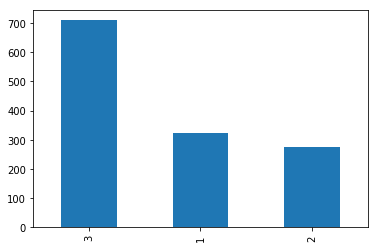

In [109]:
fig = plt.figure()

# Histograms for travel class attributes
df = titanicData.pclass.astype('category')
df.value_counts().plot(kind='bar')

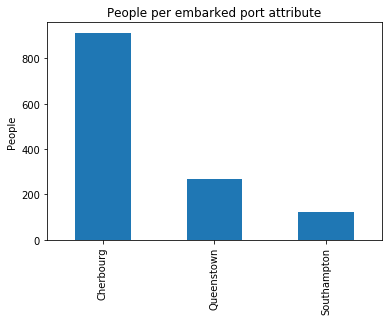

In [110]:
# Histograms for embarkation port attributes (Cherbourg Queenstown Southampton)
df = titanicData.embarked.astype('category')
embarkedPlot = df.value_counts().plot(kind='bar')
embarkedPlot.set_title("People per embarked port attribute")
embarkedPlot.set_ylabel("People")
embarkedPlot.set_xticklabels(["Cherbourg", "Queenstown", "Southampton"])

[<matplotlib.text.Text at 0x11cfb24a8>, <matplotlib.text.Text at 0x11cfd61d0>]

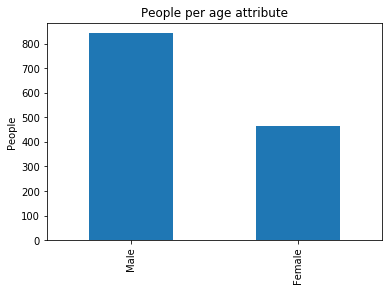

In [ ]:
# Histograms for sex attributes

df = titanicData.sex.astype('category')
sexPlot = df.value_counts().plot(kind='bar')
sexPlot.set_title("People per age attribute")
sexPlot.set_ylabel("People")
sexPlot.set_xticklabels(["Male", "Female"])

In [ ]:
# Histogram for age attributes with discrete intervals ([0,10])

begin, end, interval = 10, 100, 10

titanicDataTmp, ageDiscret, ageInd = titanicData.sort_values(['age']), [], list(range(begin, end, interval))

# Count the number of people in each interval of ten years
ageDiscret.append(titanicDataTmp.query('age < 10').shape[0])

for i in range(20,100,interval):
    j = i - 10
    ageDiscret.append(titanicDataTmp.query('age < @i').shape[0] - titanicDataTmp.query('age < @j').shape[0])    
    
# Bar plot   
plt.bar(ageInd, ageDiscret,  width = -10, align = 'edge')
plt.title("People per age attribute")
plt.xlabel("Age (per ten decades year)")
plt.ylabel("People")
plt.show()

### 3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

In [ ]:
for i in range(1,max(titanicData.pclass) + 1):
    ClassCabin = titanicData.query('pclass == @i').cabin
    print("Class", i, ":", ClassCabin.isnull().sum(), "nan values on", ClassCabin.shape[0], "total data")

As you can see, there is many nan values for the class 2 and the class 3. That's why we will only make the pie chart fort the first class.

In [ ]:
# On vire les NAN values
titanicDataTmp = titanicData.query('pclass == 1').sort_values('cabin')

floorList = ["A", "B", "C", "D", "E", "F", "G"]
floorListPro = [0] * len(floorList) #np.zeros(len(floorList))

for cabin in titanicDataTmp['cabin']:
    if not(pd.isnull(cabin)):        
        cabinFloor = list(cabin)[0]
        
        for i in range(len(floorList)):
            if cabinFloor == floorList[i]:
                floorListPro[i] += 1

                
print("Number of first class passengers in each floor: ")
for i in range(0, len(floorList)):
    print("Floor {}.: {}".format(floorList[i],floorListPro[i]))

Passengers that travelled in First Class didn't had cabins in the floors F and G.

In [ ]:
floorListPro = np.delete(floorListPro, [len(floorListPro)-1,len(floorListPro)-2], 0)
floorList = np.delete(floorList, [len(floorList)-1,len(floorList)-2], 0)
# Pie chart

plt.pie(floorListPro, labels = floorList, autopct = '%1.1f%%')
plt.axis('equal')
plt.title('Repartition of the First class Passengers by floor')
plt.show()

#### 4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

In [104]:
nbSurvivors = np.zeros(3,)
    
for pclass in range(1,4):
    nbSurvivors[pclass-1] = titanicData.query('pclass == @pclass').query('survived == 1').shape[0]

print("Number of survivors in each class: ")
for i in range(1, len(nbSurvivors)+1):
    print("Class {}.: {}".format(i,int(nbSurvivors[i-1])))

Number of survivors in each class: 
Class 1.: 200
Class 2.: 119
Class 3.: 181


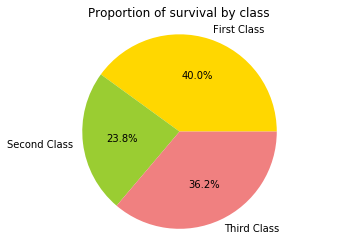

In [96]:
labels = 'First Class', 'Second Class', 'Third Class'
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(nbSurvivors,labels=labels, colors=colors,autopct='%1.1f%%')
 
plt.axis('equal')
plt.title('Proportion of survival by class')
plt.show()

#### 5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

In [103]:
nbSurvivors = np.zeros((3,2))
    
for pclass in range(1,4):
    for gender in range(2):
        nbSurvivors[pclass - 1, gender] = titanicData.query('pclass == @pclass').query('sex == @gender').query('survived == 1').shape[0]

print("number of survivors by sex and class:")
for i,j in nbSurvivors:
    print('Firt class: {} women and {} men' .format(int(i),int(j)))
    
np.arange(nbSurvivors.shape[0])


number of survivors by sex and class:
Firt class: 139 women and 61 men
Firt class: 94 women and 25 men
Firt class: 106 women and 75 men


array([0, 1, 2])

In [105]:
ind = np.arange(nbSurvivors.shape[0])
width = 0.35       

p1 = plt.bar(ind, nbSurvivors[:,0], width, color='#d62728')
p2 = plt.bar(ind, nbSurvivors[:,1], width,)

plt.ylabel('Scores')
plt.title('Proportion of the passengers that survived by travel class and sex')
plt.xticks(ind, ('First class', 'Second class', 'Third class'))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()


IndexError: too many indices for array

#### 6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

Nous avons supprimés toutes les lignes où un survivant n'avait pas d'âge.

In [198]:
def survivals_proportions(data):
    
    ratioClass, ratioSex, nb = [], [], int(data.shape[0]/2)

    # Survival proportions by age category 
    ratioAge = data.query('survived == 1').shape[0]/nb # nb people alive / nb people total
    
    # Survival proportions by travel class
    nbClass = max(data.pclass)

    for pclass in range(1, nbClass + 1):
        nb = data[data.pclass == pclass].shape[0]
        ratioClass.append(data.query('pclass == @pclass').query('survived == 1').shape[0]/nb)

    # Survival proportions by sex
    for sex in range(2):
        nb = data[data.sex == sex].shape[0]
        ratioSex.append(data.query('sex == @sex').query('survived == 1').shape[0]/nb)
                      
    return ratioAge, ratioClass, ratioSex

In [199]:
# Keep only people who's don't have nan value for age and sort datafram by age
titanicDataTmp = titanicData.sort_values(['age']).dropna(subset = ['age'])

nb = int(titanicDataTmp.shape[0]/2)

ratioAge, ratioClass, ratioSex = np.zeros(2), np.zeros((2,3)), np.zeros((2,2))

# First age category
ratioAge[0], ratioClass[0, :], ratioSex[0, :] = survivals_proportions(titanicDataTmp.head(nb))

# Second age category
ratioAge[1], ratioClass[1, :], ratioSex[1, :] = survivals_proportions(titanicDataTmp.tail(nb))

#print(ratioAge,   end = "\n\n")
#print(ratioClass, end = "\n\n")
#print(ratioSex,   end = "\n\n")

In [202]:
# Datafram creation

data = pd.DataFrame({'Age categorie':['1er','2nd'], 
                     'Ratio Age':ratioAge,
                     'First Class':ratioClass[:,0],
                     'Second Class':ratioClass[:,1],
                     'Third Class':ratioClass[:,2],
                     'Female':ratioSex[:,0],
                     'Male':ratioSex[:,1]})

# Data reorganization
data = data[['Age categorie','Ratio Age','First Class','Second Class','Third Class','Female','Male']]
data

,Age categorie,Ratio Age,First Class,Second Class,Third Class,Female,Male
0,1er,0.823755,0.760563,0.516129,0.295732,0.707921,0.224299
1,2nd,0.812261,0.596244,0.372263,0.196532,0.801075,0.186944


In [201]:
# Is the index unique ?
data.index.is_unique

True

### Discussion

- De manière général, plus d'hommes sont morts (stratégie "les femmes et les enfants d'abords" ?). 
- Dans la première classe, il y a également un taux de survie plus haut : les riches avaient accès à plus de bateau de sauvetage ?
- On voit pas de diff différance vraiment notable entre les deux classe d'age, surement à cause du fait que trop de personnes sont autour de la moyenne : plein de gens d'environ 28 ans sont dans les deux classes -> ça nique l'interprétation qu'on peut faire des données.